In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
import gc

In [3]:
from utils import *

In [4]:
conf = {
    'bs':180,
    'emb_size':256,
    'arch':resnet34,
    'split':0
}

In [5]:
PATH = Path('../input/shopee-product-matching')
model_file  = '../input/resnet-model/resnet34.pth'
if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    model_file ='models/resnet34.pth'

In [6]:
TAKE_PAIRS = 7

In [28]:
def hash_label(x):
    x = (13*x)%10000
    return x // 2000
train_df = pd.read_csv(PATH/'train.csv')
train_df['split']=train_df.label_group.apply(hash_label)
train_df['is_valid'] = train_df.split==conf['split']
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

## TEXT

In [8]:
def csr_matrix_to_tensor(csr):
    coo = csr.tocoo()
    t = torch.sparse_coo_tensor([coo.row, coo.col], coo.data, csr.shape).cuda()
    return t

def do_chunk_text(embs):
    step = 5000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, embs.shape[0])
        chunk = embs[chunk_start:chunk_end]
        chunk = csr_matrix_to_tensor(chunk).to_dense()
        yield chunk

def generate_text_pairs(data):
    sk_model = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
    text_embeddings =sk_model.fit_transform(data.title)
    sparse_embs = csr_matrix_to_tensor(text_embeddings)
    dists, inds = get_nearest(sparse_embs, do_chunk_text(text_embeddings))
    pairs = sorted_pairs(dists, inds)[:int(len(data)*TAKE_PAIRS)]
    return pairs

## IMAGE


In [9]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [10]:
def embs_from_resnet(model, dl):
    model_stem =list(model.children())[0].eval()
    pipeline = nn.Sequential(model_stem, AdaptiveConcatPool2d(), Flatten())
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = pipeline(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    all_embs = F.normalize(torch.cat(all_embs))
    return all_embs, torch.cat(all_ys)

In [11]:
def do_chunk_img(embs):
    step = 10000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]

In [12]:
def generate_image_pairs(model, dl):
    embs, _ = embs_from_resnet(model, dl)
    dists, inds = get_nearest(embs, do_chunk_img(embs))
    pairs = sorted_pairs(dists, inds)[:int(len(embs)*TAKE_PAIRS)]
    return pairs

In [13]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'])
learn = cnn_learner(dls,conf['arch'], pretrained=False,path='../input', model_dir='resnet-model')
state = torch.load(model_file)['model']
learn.model.load_state_dict(state, strict=True)

<All keys matched successfully>

## COMBINE

In [14]:
def weave(A,B):
    R = list()
    used = set()
    for a,b in zip(A,B):
        if a[:2] not in used:
            R.append(a)
            used.add(a[:2])
        if b[:2] not in used:
            R.append(b)
            used.add(b[:2])
    return R

## Check on validation set

0.782 at 5.600910663604736 pairs


  0%|          | 0/38 [00:00<?, ?it/s]

0.746 at 4.122355937957764 pairs
0.844 at 5.333871841430664 pairs


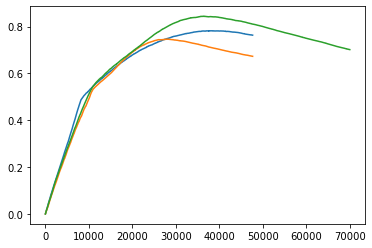

In [15]:
text_pairs = generate_text_pairs(valid_df)

_=build_from_pairs(text_pairs, valid_df.target.to_list())

img_pairs = generate_image_pairs(learn.model.cuda(), dls.valid)

_=build_from_pairs(img_pairs, valid_df.target.to_list())

combined = weave(text_pairs, img_pairs)

_=build_from_pairs(combined, valid_df.target.to_list())

## Run on the test set

In [16]:
test_df = pd.read_csv(PATH/'test.csv')

In [17]:
fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
fake_test_df = pd.concat([fake_test_df, fake_test_df])
fake_test_df = add_target_groups(fake_test_df)
test_df = fake_test_df

In [18]:
text_pairs = generate_text_pairs(test_df)

In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
test_dl = dls.test_dl(test_df)
img_pairs = generate_image_pairs(learn.model.cuda(), test_dl)

  0%|          | 0/381 [00:00<?, ?it/s]

In [23]:
combined = weave(text_pairs, img_pairs)[:int(len(test_df)*TAKE_PAIRS)]

0.645 at 6.999576568603516 pairs
0.692 at 6.999518394470215 pairs
0.725 at 6.99947452545166 pairs


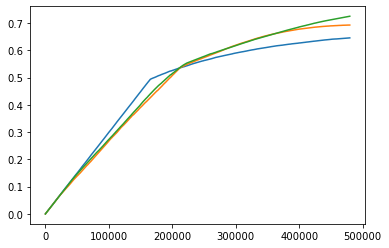

In [24]:
if 'target' in test_df.columns.to_list():
    _=build_from_pairs(text_pairs, test_df.target.to_list())
    _=build_from_pairs(img_pairs, test_df.target.to_list())
    _=build_from_pairs(combined, test_df.target.to_list())

In [25]:
groups = [[] for _ in range(len(test_df))]
for x,y,v in combined:
    groups[x].append(y)

In [26]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)